In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout,SimpleRNN, GRU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

from cv2 import imread, resize

In [2]:
data = pd.read_csv('../input/water-quality/waterQuality1.csv')

data = data.drop('ammonia', axis = 1)
data = data.drop('flouride', axis = 1)
data = data.drop('selenium', axis = 1)
data = data.drop('uranium', axis = 1)

data = data[data['is_safe'] != '#NUM!']
data['is_safe'] = data['is_safe'].astype(int)

columns = dict(zip(list(range(data.shape[1])), data.columns.values.tolist()))
is_safe = data['is_safe']

data = pd.DataFrame(StandardScaler().fit_transform(data)).rename(columns = columns)
data['is_safe'] = is_safe
data = data.dropna()
data.head(6)


,aluminium,arsenic,barium,cadmium,chloramine,chromium,copper,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,silver,is_safe
0,0.777403,-0.480875,1.054205,-0.993241,-0.711941,2.152993,-0.973050,-0.363345,-0.869387,-0.781070,1.129767,-0.348629,0.609178,1.203362,1.661842,1.338736,1.0
1,1.306945,-0.599632,1.432447,-1.131948,1.208552,1.598765,-0.223303,1.002460,0.849782,0.009785,-1.409197,1.046960,-0.739005,0.892977,0.124811,0.851134,1.0
2,0.271572,-0.480875,-0.812340,-0.965499,0.803417,1.044536,-1.202564,-0.818614,-0.861452,-0.368450,0.783298,-0.383518,0.272132,1.911763,1.786699,2.035310,0.0
3,0.548198,-0.480875,1.144654,-1.159690,1.968179,-0.802892,1.306793,1.184567,1.008475,-1.434385,-1.517469,-0.069511,-0.401960,-0.415275,-0.516695,2.104968,1.0
4,0.200439,-0.520460,-1.124801,-1.020982,0.191820,1.635713,-0.361012,-0.575804,-0.866742,0.302058,-0.555658,-0.383518,-0.739005,0.024578,-0.219622,-0.611672,1.0
5,0.216246,-0.520460,1.078873,-1.104207,-0.536643,0.675051,0.878366,1.063162,0.902680,0.611523,-0.012496,0.977180,0.272132,0.605207,1.076306,0.293875,1.0


In [3]:
x = data.drop('is_safe', axis = 1)
y = data['is_safe']

from collections import Counter
from imblearn.over_sampling import SMOTE

counter = Counter(y)
print(counter)


oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 25)

y_train = np.expand_dims(y_train, axis = -1)
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
y_tset = np.expand_dims(x_test, axis = -1)

counter = Counter(y)
print(counter)
print(y_train.shape)
print(x_train.shape)

Counter({0.0: 7084, 1.0: 909})
Counter({1.0: 7084, 0.0: 7084})
(11334, 1)
(11334, 16, 1)


In [4]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')


In [5]:
model = Sequential()
model.add(GRU(128, input_shape=(16,1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

2022-10-31 18:12:28.917449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 18:12:28.918462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 18:12:29.097091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 18:12:29.098005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 18:12:29.098881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [7]:
history = model.fit(x_train,
          y_train,
          epochs= 150,
          batch_size = 200,
          validation_split=0.2,
          callbacks=[early])

2022-10-31 18:12:33.332809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
46/46 [==============================] - 6s 56ms/step - loss: 0.7215 - accuracy: 0.5536 - val_loss: 0.6937 - val_accuracy: 0.4901
Epoch 2/150
46/46 [==============================] - 3s 58ms/step - loss: 0.6593 - accuracy: 0.6129 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 3/150
46/46 [==============================] - 2s 47ms/step - loss: 0.5231 - accuracy: 0.7605 - val_loss: 0.6788 - val_accuracy: 0.5137
Epoch 4/150
46/46 [==============================] - 2s 48ms/step - loss: 0.4511 - accuracy: 0.8158 - val_loss: 0.6634 - val_accuracy: 0.5798
Epoch 5/150
46/46 [==============================] - 3s 55ms/step - loss: 0.4297 - accuracy: 0.8270 - val_loss: 0.6367 - val_accuracy: 0.6792
Epoch 6/150
46/46 [==============================] - 2s 46ms/step - loss: 0.4232 - accuracy: 0.8280 - val_loss: 0.6206 - val_accuracy: 0.7681
Epoch 7/150
46/46 [==============================] - 2s 47ms/step - loss: 0.4164 - accuracy: 0.8323 - val_loss: 0.5877 - val_accuracy: 0.8345
Epoch 

In [8]:
evaluation=model.evaluate(x_test, y_test, verbose=1)

89/89 [==============================] - 1s 6ms/step - loss: 0.3855 - accuracy: 0.8365


Text(0, 0.5, 'accuracy')

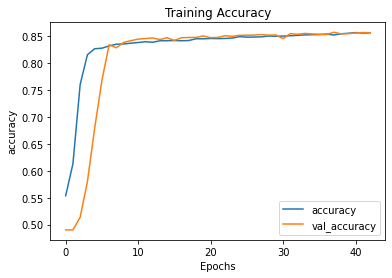

In [9]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")

Text(0, 0.5, 'Loss')

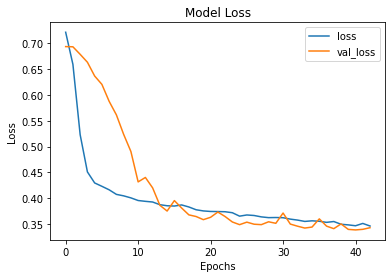

In [10]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")